In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model():    
    model = keras.Sequential([
        keras.layers.Dense(
            90, 
            activation='relu',
            input_shape=(train_features.shape[-1],)
        ),        
        keras.layers.Dense(
            90, 
            activation = 'relu'
        ),
        keras.layers.Dense(
            90, 
            activation = 'relu'
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(
            1, 
            activation='sigmoid',
            bias_initializer=output_bias
        ),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall', 'fp', 'fn']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.8,1])
        
    else:
        #plt.ylim([0,1])
        plt.legend()
        
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    normalized_cm = cm / len(labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(normalized_cm, annot=True)
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No fire (True Negatives): ', cm[0][0])
    print('False alarms (False Positives): ', cm[0][1])
    print('Fires missed (False Negatives): ', cm[1][0])
    print('Fires detected (True Positives): ', cm[1][1])
    print('Total fires: ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [5]:
data_file = '../data/stratified_training_data/1992-2015_training_data_added_features_n500000_ks_pval0.2.1.csv'
validation_file = '../data/stratified_training_data/1992-2015_training_data_added_features_n500000_ks_pval0.2.2.csv'
test_file = '../data/stratified_training_data/1992-2015_training_data_added_features_n500000_ks_pval0.2.3.csv'

# Datatypes for dataframe loading
dtypes = {
    'lat': float,
    'lon': float,
    'weather_bin_year': int,
    'weather_bin_month': int,
    'weather_bin_day': int,
    'air.2m': float,
    'apcp': float,
    'rhum.2m': float,
    'dpt.2m': float,
    'pres.sfc': float,
    'uwnd.10m': float,
    'vwnd.10m': float,
    'veg': float,
    'vis': float,
    'ignition': float,
    'mean.air.2m': float,
    'mean.apcp': float,
    'mean.rhum.2m': float,
    'mean.dpt.2m': float,
    'mean.pres.sfc': float,
    'mean.uwnd.10m': float,
    'mean.vwnd.10m': float,
    'mean.veg': float,
    'mean.vis': float,
    'max.air.2m': float,
    'max.apcp': float,
    'max.rhum.2m': float,
    'max.dpt.2m': float,
    'max.pres.sfc': float,
    'max.uwnd.10m': float,
    'max.vwnd.10m': float,
    'max.veg': float,
    'max.vis': float,
    'min.air.2m': float,
    'min.apcp': float,
    'min.rhum.2m': float,
    'min.dpt.2m': float,
    'min.pres.sfc': float,
    'min.uwnd.10m': float,
    'min.vwnd.10m': float,
    'min.veg': float,
    'min.vis': float,
    'total_fires': float

}

# Features to use during training 
features = [
    'lat',
    'lon',
#     'weather_bin_year',
#     'weather_bin_month',
#     'weather_bin_day',
#     'air.2m',
#     'apcp',
#     'rhum.2m',
#     'dpt.2m',
#     'pres.sfc',
#     'uwnd.10m',
#     'vwnd.10m',
    'veg',
#     'vis',
    'ignition',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
#     'mean.veg',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
#     'max.veg',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
#     'min.veg',
    'min.vis',
    'total_fires'
]

In [6]:
data = pd.read_csv(data_file, dtype=dtypes)
validation = pd.read_csv(validation_file, dtype=dtypes)
test = pd.read_csv(test_file, dtype=dtypes)

In [7]:
data.describe()

,lat,lon,weather_bin_year,weather_bin_month,weather_bin_day,air.2m,apcp,rhum.2m,dpt.2m,pres.sfc,...,min.air.2m,min.apcp,min.rhum.2m,min.dpt.2m,min.pres.sfc,min.uwnd.10m,min.vwnd.10m,min.veg,min.vis,total_fires
count,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,...,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000,449258.000000
mean,37.118790,-119.520017,2003.497458,6.522455,15.723168,287.946467,0.174730,49.260590,274.730968,91532.102608,...,282.784183,0.022633,34.984869,272.170843,91321.262559,-0.855009,-1.758363,30.626589,16405.975847,3261.030677
std,2.555059,2.505750,6.920245,3.447950,8.796622,9.153630,0.693293,23.671230,7.077070,6965.637136,...,7.918630,0.172581,22.150176,7.752162,6957.168334,2.210803,2.802363,22.728086,6208.137544,4645.251644
min,32.683890,-124.340800,1992.000000,1.000000,1.000000,251.068295,0.000000,1.168596,227.721058,67596.480625,...,249.747777,0.000000,1.000000,202.716087,67169.433750,-16.928171,-19.876152,0.000000,4.403342,0.000000
25%,34.990290,-121.470900,1997.000000,4.000000,8.000000,281.674369,0.000000,28.964122,270.000159,87155.258406,...,277.416624,0.000000,16.966489,267.203472,86951.762125,-2.230729,-3.375806,8.200000,15281.935350,184.000000
50%,36.794300,-119.905100,2003.000000,7.000000,16.000000,287.329884,0.000542,46.691701,275.257458,92322.748500,...,282.557484,0.000000,29.483080,272.762984,92096.414250,-0.867268,-1.758848,30.500000,20005.715375,1856.000000
75%,39.259700,-117.411700,2010.000000,10.000000,23.000000,294.303815,0.009792,69.054688,280.006030,97091.430969,...,287.888940,0.000000,48.790885,277.788696,96880.567250,0.590051,0.117434,43.600000,20007.502750,4168.000000
max,41.971820,-114.364500,2015.000000,12.000000,31.000000,315.965299,23.148791,99.491829,295.070841,103197.876250,...,307.704224,10.687500,96.902775,294.225976,102855.697750,12.050169,18.705453,83.700000,20018.515425,38368.000000


In [8]:
# count number of observations in each class
total = len(data)
no_ignition_count = len(data[data["ignition"] == 0])
ignition_count = total - no_ignition_count
print('Total training observations: {:.2E}'.format(total))
print(' Ignitions count: {:.2E} ({}%)'.format(ignition_count,np.round(((ignition_count/total)*100),1)))
print(' Non ignitions count: {:.2E} ({}%)'.format(no_ignition_count, np.round(((no_ignition_count/total)*100),1)))

Total training observations: 4.49E+05
 Ignitions count: 1.65E+04 (3.7%)
 Non ignitions count: 4.33E+05 (96.3%)


In [9]:
# Pull out columns for X (data to train with) and Y (value to predict)
training_data = data[features]
validation_data = validation[features]
test_data = test[features]

In [10]:
# Form np arrays of labels and features.
train_labels = np.array(training_data.pop('ignition'))
bool_train_labels = train_labels != 0
val_labels = np.array(validation_data.pop('ignition'))
test_labels = np.array(test_data.pop('ignition'))

train_features = np.array(training_data)
val_features = np.array(validation_data)
test_features = np.array(test_data)

In [11]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (449258,)
Validation labels shape: (449257,)
Test labels shape: (449258,)
Training features shape: (449258, 28)
Validation features shape: (449257, 28)
Test features shape: (449258, 28)


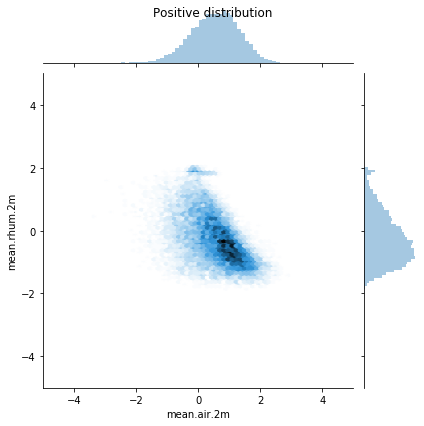

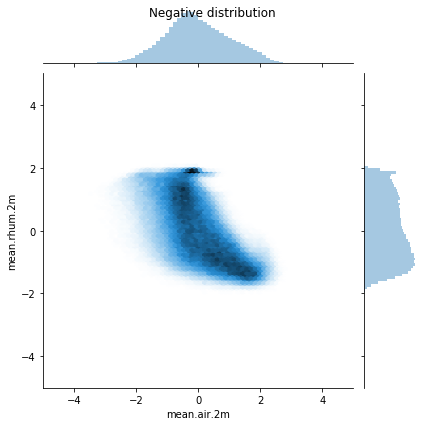

In [12]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = training_data.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = training_data.columns)

sns.jointplot(
    pos_df['mean.air.2m'], 
    pos_df['mean.rhum.2m'],
    kind='hex', 
    xlim = (-5,5), 
    ylim = (-5,5)
)

plt.suptitle("Positive distribution")

sns.jointplot(
    neg_df['mean.air.2m'], 
    neg_df['mean.rhum.2m'],
    kind='hex', 
    xlim = (-5,5), 
    ylim = (-5,5)
)

_ = plt.suptitle("Negative distribution")

In [13]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / no_ignition_count)*(total)/2.0 
weight_for_1 = (1 / ignition_count)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

initial_bias = np.log([ignition_count/no_ignition_count])
output_bias = tf.keras.initializers.Constant(initial_bias)

print('Inital bias: {}'.format(initial_bias))

EPOCHS = 15
BATCH_SIZE = 2048 * 30

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Weight for class 0: 0.52
Weight for class 1: 13.65
Inital bias: [-3.26977945]


In [14]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 90)                2610      
_________________________________________________________________
dense_1 (Dense)              (None, 90)                8190      
_________________________________________________________________
dense_2 (Dense)              (None, 90)                8190      
_________________________________________________________________
dropout (Dropout)            (None, 90)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 91        
Total params: 19,081
Trainable params: 19,081
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight
) 

Train on 449258 samples, validate on 449257 samples
Epoch 1/15
449258/449258 [==============================] - 6s 14us/sample - loss: 1.4506 - tp: 21.0000 - fp: 2828.0000 - tn: 429977.0000 - fn: 16432.0000 - accuracy: 0.9571 - precision: 0.0074 - recall: 0.0013 - auc: 0.4748 - val_loss: 1.0101 - val_tp: 93.0000 - val_fp: 13492.0000 - val_tn: 419553.0000 - val_fn: 16119.0000 - val_accuracy: 0.9341 - val_precision: 0.0068 - val_recall: 0.0057 - val_auc: 0.4822
Epoch 2/15
449258/449258 [==============================] - 3s 7us/sample - loss: 0.8879 - tp: 3629.0000 - fp: 83747.0000 - tn: 349058.0000 - fn: 12824.0000 - accuracy: 0.7850 - precision: 0.0415 - recall: 0.2206 - auc: 0.5209 - val_loss: 0.6838 - val_tp: 9911.0000 - val_fp: 186449.0000 - val_tn: 246596.0000 - val_fn: 6301.0000 - val_accuracy: 0.5710 - val_precision: 0.0505 - val_recall: 0.6113 - val_auc: 0.6375
Epoch 3/15
449258/449258 [==============================] - 3s 7us/sample - loss: 0.7210 - tp: 10578.0000 - fp: 184986.0

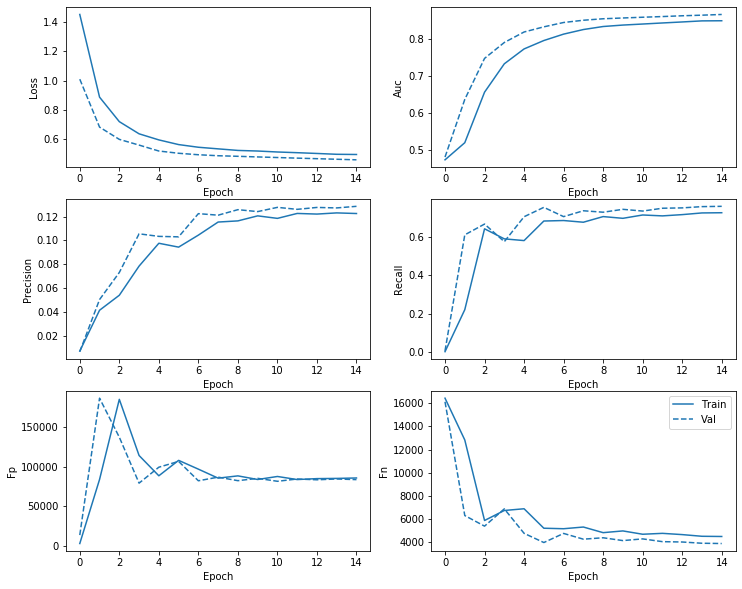

In [19]:
plot_metrics(history)

In [ ]:
train_predictions = model.predict(train_features, batch_size=len(train_features))
test_predictions = model.predict(test_features, batch_size=len(test_features))

results = model.evaluate(
    test_features,
    test_labels,
    batch_size=BATCH_SIZE, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions, p=0.1)

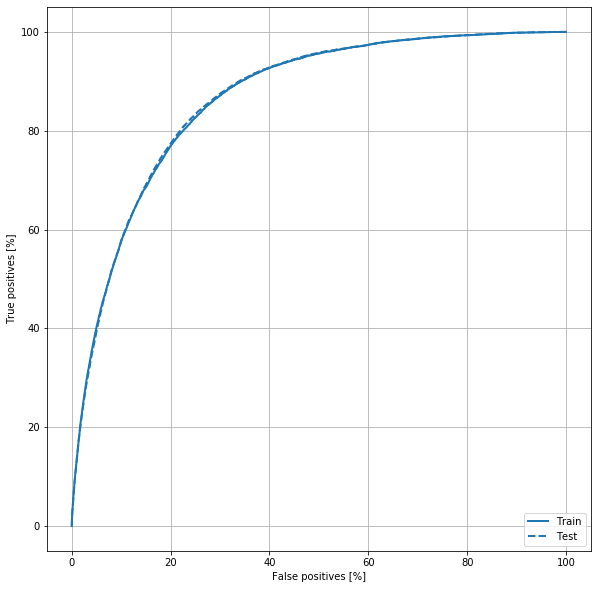

In [23]:
plot_roc("Train", train_labels, train_predictions, color=colors[0])
plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')

plt.legend(loc='lower right')

plt.show()